<a href="https://colab.research.google.com/github/abhinav9629/JPEGUP/blob/main/Jpeg2SRJpeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models import vgg19
from PIL import Image
import albumentations as A
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [7]:
# import shutil
# import os

# source = '/content/drive/MyDrive/SR_Data/DIV2K_train_HR'
# destination = '/content/test_images'

# # gather all files
# filess = []
# allfiles = os.listdir(source)
# for files in allfiles:
#   if files.endswith("x4.png") and len(filess) < 21:
#     filess.append(files)

# # iterate on all files to move them to destination folder
# for f in filess:
#     src_path = os.path.join(source, f)
#     dst_path = os.path.join(destination, f)
#     shutil.copy(src_path, dst_path)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
load_model = True
save_model = True
chkpt_gen = "/content/drive/MyDrive/SR_Data/SR_Checkpoints/generator.pth.tar"
chkpt_disc = "/content/drive/MyDrive/SR_Data/SR_Checkpoints/discriminator.pth.tar"
learning_rate = 1e-4
epochs = 101
batch_size = 16
num_workers = 4
high_res_size = 96
low_res_size = 24
img_channels = 3

In [9]:
high_res_transform = A.Compose(
    [
        A.Normalize(mean=[0.5 for _ in range(img_channels)], std=[0.5 for _ in range(img_channels)]),
        ToTensorV2(),
    ]
)

low_res_transform = A.Compose(
    [
        A.Resize(width = low_res_size, height = low_res_size, interpolation = Image.BICUBIC),
        A.Normalize(
            mean = [0 for _ in range(img_channels)], std = [1 for _ in range(img_channels)]
        ),
        ToTensorV2(),
    ]
)

both_transform = A.Compose(
    [
          A.RandomCrop(width = high_res_size , height = high_res_size),
          A.HorizontalFlip(p = 0.5),
          A.RandomRotate90(p = 0.5),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(
            mean = [0 for _ in range(img_channels)], std = [1 for _ in range(img_channels)]
        ),
        ToTensorV2(),
    ]
)

In [10]:
class ImageDataset():
  def __init__(self, path_dir):
    self.data = []
    self.target = []
    self.path_dir = path_dir

    for files in os.listdir(self.path_dir):
      if files.endswith("x4.png"):
        self.data.append(files)
      else:
        self.target.append(files)

    self.data = sorted(self.data)
    self.target = sorted(self.target)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    label_name = self.data[index]
    image_name = self.target[index]
    image = np.asarray(Image.open(os.path.join(self.path_dir,image_name)))
    image = both_transform(image=image)["image"]
    high_res = high_res_transform(image = image)["image"]
    low_res = low_res_transform(image = image)["image"]

    return low_res, high_res

In [11]:
class C_Block(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size, stride, padding, disc = False, use_activation = True, use_batchnorm = True ):
     super().__init__()
     self.convnet = nn.Conv2d(in_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding, bias = not use_batchnorm)
     self.bn = nn.BatchNorm2d(out_ch) if use_batchnorm else nn.Identity()
     self.act = nn.LeakyReLU(0.2, inplace= True) if disc else nn.PReLU(num_parameters = out_ch)
     self.use_activation = use_activation

  def forward(self, input):
    x = self.convnet(input)
    x = self.bn(x)
    return self.act(x) if self.use_activation else x

In [12]:
class US_Block(nn.Module):
  def __init__(self, in_ch, scale):
    super().__init__()
    self.convnet = nn.Conv2d(in_ch, in_ch*scale**2, kernel_size = 3, stride = 1, padding=1)
    self.ps = nn.PixelShuffle(scale)
    self.act = nn.PReLU(num_parameters = in_ch)

  def forward(self, input):
    x = self.convnet(input)
    x = self.ps(x)
    return self.act(x)

In [13]:
class ResidualNet_Block(nn.Module):
  def __init__(self, in_ch):
    super().__init__()
    self.block1 = C_Block(in_ch, in_ch, kernel_size = 3, stride = 1, padding = 1 )
    self.block2 = C_Block(in_ch, in_ch, kernel_size = 3, stride = 1, padding = 1, use_activation = False)

  def forward(self, input):
    x = self.block1(input)
    out = self.block2(x)
    return out + input

In [14]:
class Generator(nn.Module):
  def __init__(self, in_ch = 3, num_ch = 64, num_blocks = 16):
    super().__init__()
    self.init_convnet = C_Block(in_ch, num_ch, kernel_size = 9, stride = 1, padding = 4, use_batchnorm=False)
    self.residual = nn.Sequential(
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
        ResidualNet_Block(num_ch),
    )
    self.convnet = C_Block(num_ch, num_ch, kernel_size = 3, stride = 1, padding = 1, use_activation = False)
    self.upsamples = nn.Sequential(
        US_Block(num_ch,scale = 2),
        US_Block(num_ch,scale = 2),
    )
    self.final_convnet = nn.Conv2d(num_ch, in_ch, kernel_size = 9, stride = 1, padding = 4)

  def forward(self, input):
    initial = self.init_convnet(input)
    x = self.residual(initial)
    x = self.convnet(x) + initial
    x = self.upsamples(x)
    out = self.final_convnet(x)
    return torch.tanh(out)


In [15]:
class Discriminator(nn.Module):
  def __init__(self, in_ch = 3, features = 64):
    super().__init__()
    self.convnet = nn.Sequential(
        C_Block(in_ch, features, kernel_size = 3, stride = 1, padding = 1, disc = True, use_activation = True, use_batchnorm = False ),
        C_Block(features, features, kernel_size = 3, stride = 2, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features, features*2, kernel_size = 3, stride = 1, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features*2, features*2, kernel_size = 3, stride = 2, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features*2, features*4, kernel_size = 3, stride = 1, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features*4, features*4, kernel_size = 3, stride = 2, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features*4, features*8, kernel_size = 3, stride = 1, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
        C_Block(features*8, features*8, kernel_size = 3, stride = 2, padding = 1, disc = True, use_activation = True, use_batchnorm = True ),
    )
    self.dense = nn.Sequential(
        nn.AdaptiveAvgPool2d((6,6)),
        nn.Flatten(),
        nn.Linear(512*6*6, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024,1),
    )

  def forward(self, input):
    x = self.convnet(input)
    out = self.dense(x)
    return out

In [16]:
# def test():
#   low_res = 24
#   with torch.cuda.amp.autocast():
#     x = torch.randn((5, 3, low_res,low_res))
#     gen = Generator()
#     disc = Discriminator()
#     gen_out = gen(x)
#     disc_out = disc(gen_out)
#     print(gen_out.shape)
#     print(disc_out.shape)
# test()

In [17]:
class VGGLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = vgg19(pretrained = True).features[:36].eval().to(device)
    self.loss = nn.MSELoss()

    for param in self.vgg.parameters():
      param.requires_grad = False

  def forward(self, input, target):
    vgg_inp_feat  = self.vgg(input)
    vgg_tar_feat  = self.vgg(target)
    return self.loss(vgg_inp_feat, vgg_tar_feat)

In [18]:
def save_chkpt(model, optimizer, path="my_checkpoint.pth.tar"):
  print("=> Saving Checkpoint")
  checkpoint = {
      "state_dict" : model.state_dict(),
      "optimizer" : optimizer.state_dict()
  }
  torch.save(checkpoint,path)

def load_chkpt(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [19]:
def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)
    gen.eval()
    for fil in files:
        image = Image.open(os.path.join(low_res_folder,fil))
        with torch.no_grad():
            upscaled_img = gen(
                 test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(device)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"/content/saved/{fil}")
    gen.train()

In [20]:
train_path  = "/content/drive/MyDrive/SR_Data/DIV2K_train_HR"
dataset = ImageDataset(path_dir = train_path)
loader = DataLoader(dataset,batch_size = batch_size, shuffle = True, pin_memory = True, num_workers=2)

In [21]:
generator = Generator(in_ch = 3).to(device)
discriminator = Discriminator(in_ch = 3).to(device)
opt_gen = optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.9,0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.9,0.999))
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 107MB/s] 


In [22]:
if load_model:
  load_chkpt("/content/drive/MyDrive/SR_Data/SR_Checkpoints/Epoch200/generator.pth.tar", generator, opt_gen, learning_rate)
  load_chkpt("/content/drive/MyDrive/SR_Data/SR_Checkpoints/Epoch200/discriminator.pth.tar", discriminator, opt_disc, learning_rate)

=> Loading checkpoint
=> Loading checkpoint


In [23]:
for epoch in range(epochs):
  loop = tqdm(loader, leave= True)
  loop.set_description(f"Epoch {epoch}:")

  for batch_idx, (low_res, high_res) in enumerate(loop):
    low_res = low_res.to(device)
    high_res = high_res.to(device)

    fake = generator(low_res)
    disc_real = discriminator(high_res)
    disc_fake = discriminator(fake.detach())
    disc_loss_real = bce_loss(disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real))
    disc_loss_fake = bce_loss(disc_fake, torch.zeros_like(disc_fake))
    disc_loss  = disc_loss_real + disc_loss_fake

    opt_disc.zero_grad()
    disc_loss.backward()
    opt_disc.step()

    # l2_loss = mse_loss(fake,high_res)
    disc_fake = discriminator(fake)
    gen_gan_loss = 1e-3*bce_loss(disc_fake, torch.ones_like(disc_fake))
    vgg19_loss = 0.006*vgg_loss(fake,high_res)
    gen_loss  = gen_gan_loss + vgg19_loss
    # gen_loss = l2_loss

    opt_gen.zero_grad()
    gen_loss.backward()
    opt_gen.step()

    if batch_idx % 200 == 0:
      plot_examples("/content/test_images",generator)


  if save_model and epoch%5 == 0:
    print(f"Epoch: {epoch}, LossG_L2: {gen_loss}")
    save_chkpt(generator, opt_gen, path = "/content/drive/MyDrive/SR_Data/SR_Main/generator.pth.tar" )
    save_chkpt(discriminator, opt_disc, path = "/content/drive/MyDrive/SR_Data/SR_Main/discriminator.pth.tar")




Epoch 0:: 100%|██████████| 50/50 [02:18<00:00,  2.77s/it]


Epoch: 0, LossG_L2: 0.005114792380481958
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 5:: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


Epoch: 5, LossG_L2: 0.002400239696726203
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 10:: 100%|██████████| 50/50 [01:55<00:00,  2.32s/it]


Epoch: 10, LossG_L2: 0.002840424655005336
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 15:: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


Epoch: 15, LossG_L2: 0.0029071455355733633
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 20:: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


Epoch: 20, LossG_L2: 0.00313258683308959
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 25:: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Epoch: 25, LossG_L2: 0.001634119194932282
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 30:: 100%|██████████| 50/50 [01:53<00:00,  2.28s/it]


Epoch: 30, LossG_L2: 0.001862968085333705
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 35:: 100%|██████████| 50/50 [01:51<00:00,  2.22s/it]


Epoch: 35, LossG_L2: 0.001972142606973648
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 40:: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


Epoch: 40, LossG_L2: 0.0018135716672986746
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 45:: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


Epoch: 45, LossG_L2: 0.0028148763813078403
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 50:: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


Epoch: 50, LossG_L2: 0.002355588600039482
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 55:: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Epoch: 55, LossG_L2: 0.0025752822402864695
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 60:: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


Epoch: 60, LossG_L2: 0.002616977086290717
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 65:: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch: 65, LossG_L2: 0.002579540479928255
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 70:: 100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


Epoch: 70, LossG_L2: 0.003438025712966919
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 75:: 100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


Epoch: 75, LossG_L2: 0.0032490361481904984
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 80:: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch: 80, LossG_L2: 0.004572627600282431
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 85:: 100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


Epoch: 85, LossG_L2: 0.00392198096960783
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 90:: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


Epoch: 90, LossG_L2: 0.002807827666401863
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 95:: 100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


Epoch: 95, LossG_L2: 0.0035432786680758
=> Saving Checkpoint
=> Saving Checkpoint


Epoch 100:: 100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


Epoch: 100, LossG_L2: 0.0035732972901314497
=> Saving Checkpoint
=> Saving Checkpoint


In [29]:
def plot_examples_now(low_res_folder, gen):
    files = os.listdir(low_res_folder)
    gen.eval()
    for fil in files:
        image = Image.open(os.path.join(low_res_folder,fil))
        with torch.no_grad():
            upscaled_img = gen(
                 test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(device)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"/content/savedlast/{fil}")
    # gen.train()

In [30]:
plot_examples_now("/content/test_images", generator)

In [32]:
img_real = Image.open("/content/test_images/0001x4.png")
img_gen = Image.open("/content/savedlast/0001x4.png")

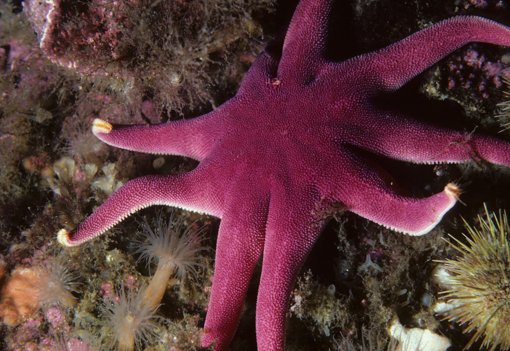

In [35]:
img_real.show()

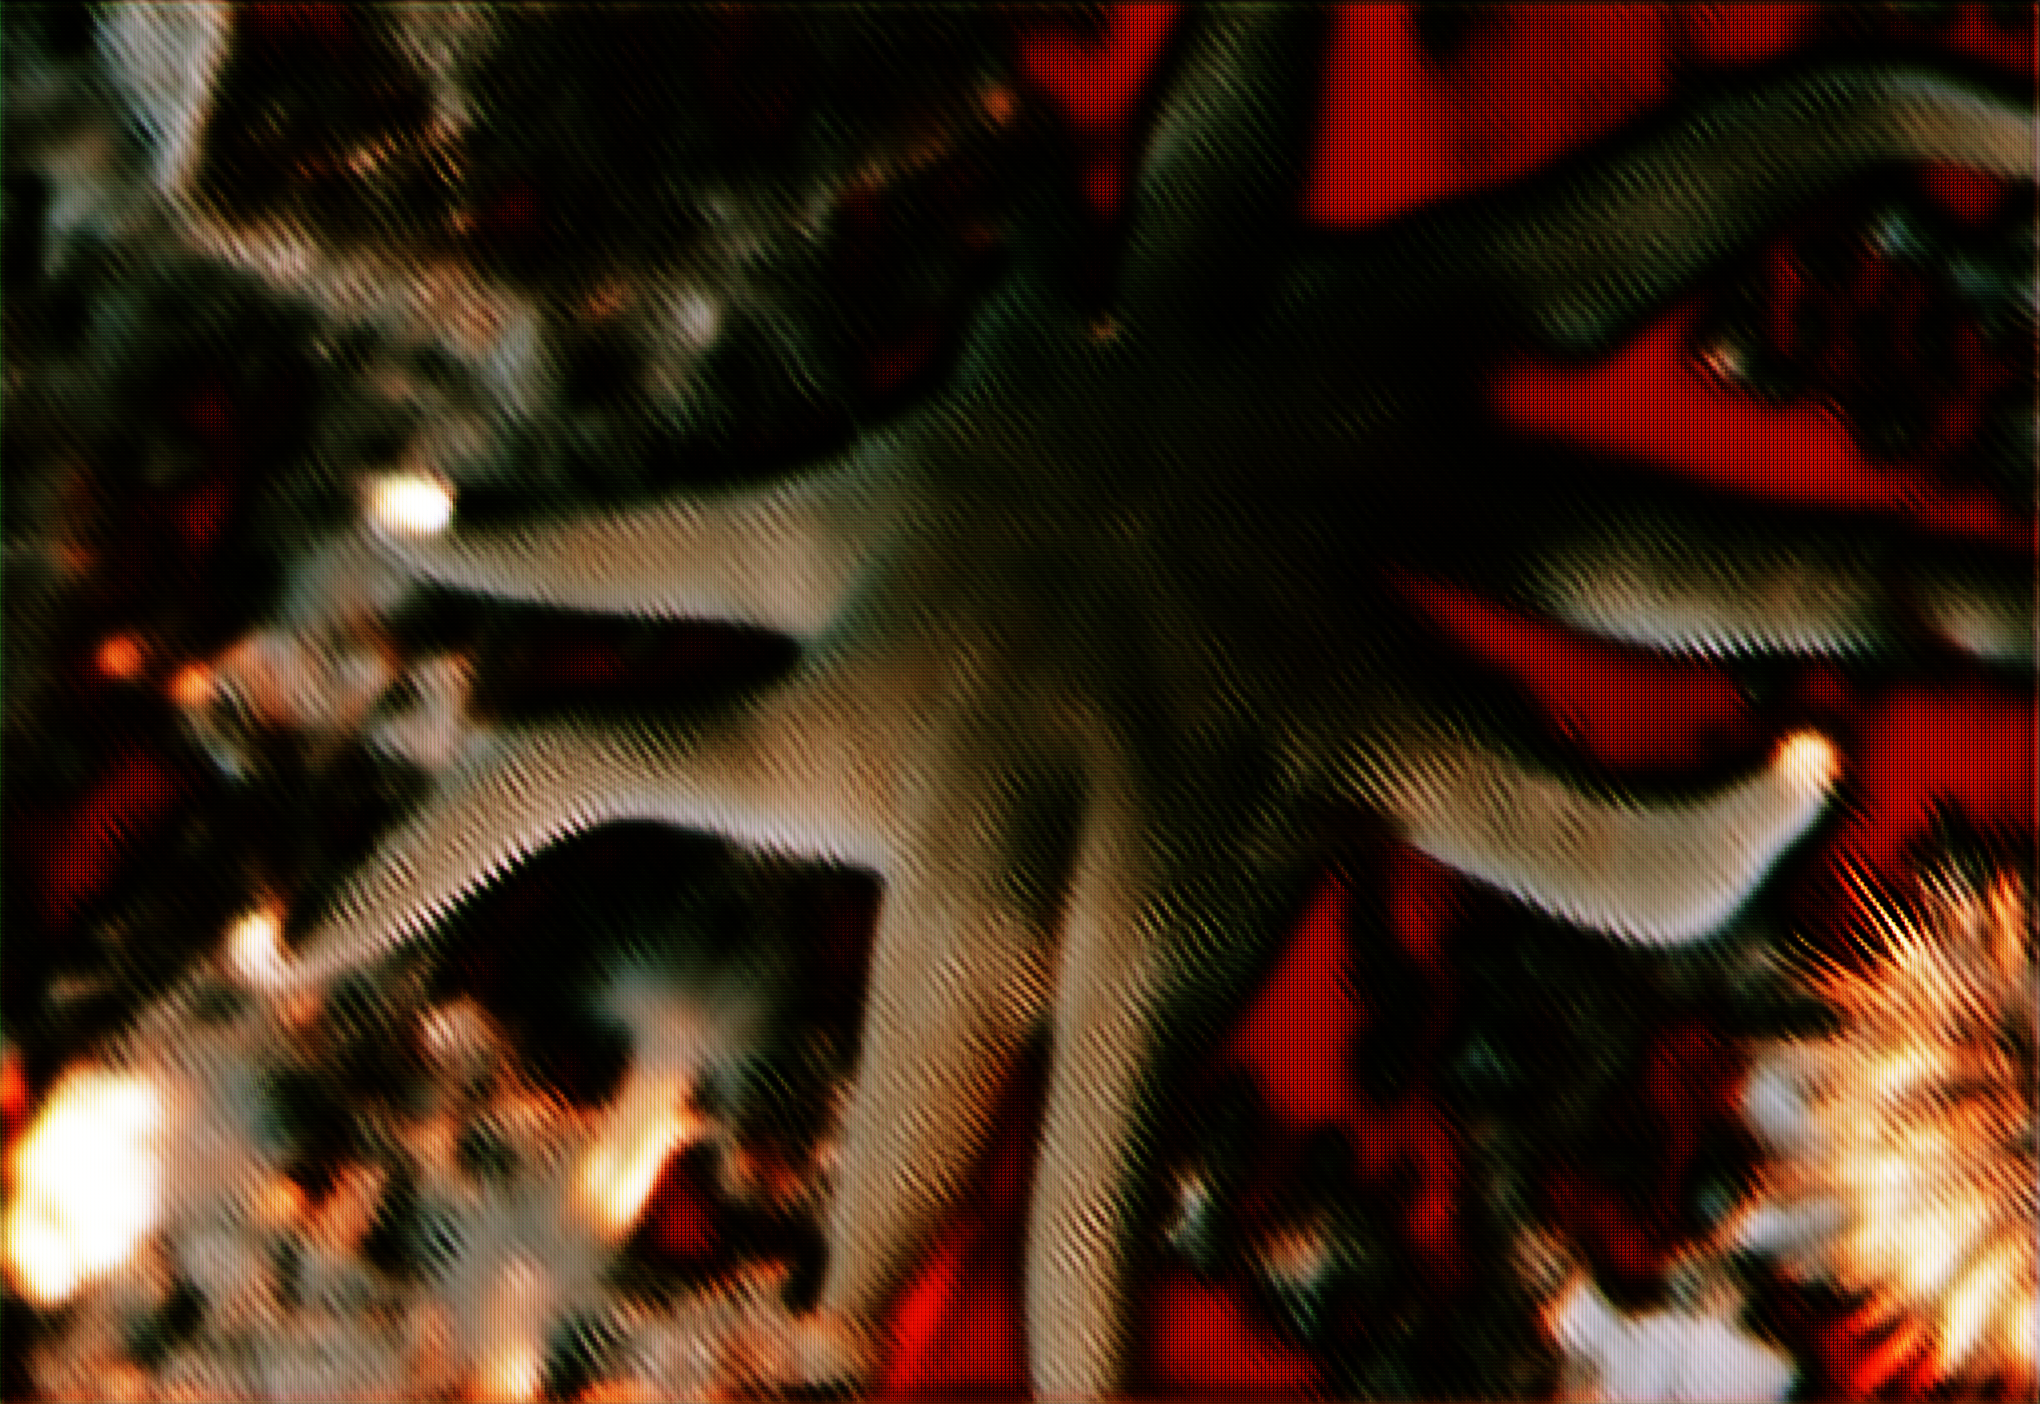

In [36]:
img_gen.show()